In [1]:
import os

import astropy.units as u
import numpy as np
import requests
from astropy.cosmology import Planck18 as cosmo
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp

from utils.cupy_utils import truncnorm, xp


In [2]:
def download_file(url, filename):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return filename
    except Exception as e:
        print(f"Error downloading file: {e}")
        return None

### Distribution Models 

- **GWTC-3** → `GWTC3_powerlaw_dip_break(mass)`  
  Power-law with a smoothed NS–BH gap and broken slope.

- **GWTC-4** → `GWTC4_broken_powerlaw_peaks(mass)`  
  Broken power-law with two truncated Gaussian peaks and smooth filters.

In [3]:
def GWTC3_powerlaw_dip_break(mass):
    """
    GWTC-3 mass distribution.
    Power-law + Dip + Break model.
    """

    # --- GWTC-3 model parameters ---
    ALPHA_1 = -2.16
    ALPHA_2 = -1.46
    A = 0.97
    M_GAP_LO = 2.72
    M_GAP_HI = 6.13
    ETA_GAP_LO = 50
    ETA_GAP_HI = 50
    ETA_MIN = 50
    ETA_MAX = 4.91
    # BETA = 1.89
    M_MIN = 1.16
    M_MAX = 54.38

    # --- Smooth filter functions ---
    def lopass(mass, m_0, eta):
        return 1 / (1 + (mass / m_0) ** eta)

    def hipass(mass, m_0, eta):
        return 1 - lopass(mass, m_0, eta)

    def bandpass(mass, m_lo, m_hi, eta_lo, eta_hi, A):
        return 1 - A * hipass(mass, m_lo, eta_lo) * lopass(mass, m_hi, eta_hi)

    # --- Combine: smoothed gap + low/high cutoffs + broken slope ---
    base = (
        bandpass(mass, M_GAP_LO, M_GAP_HI, ETA_GAP_LO, ETA_GAP_HI, A)  # NS–BH gap
        * hipass(mass, M_MIN, ETA_MIN)  # low-mass cutoff
        * lopass(mass, M_MAX, ETA_MAX)  # high-mass cutoff
        * (mass / M_GAP_HI)
        ** np.where(mass < M_GAP_HI, ALPHA_1, ALPHA_2)  # broken slope
    )

    return base



def GWTC4_broken_powerlaw_peaks(m):
    """
    GWTC-4 mass distribution.
    Broken power-law with two truncated Gaussian peaks and smooth filters.
    """
    # --- GWTC-4 model parameters ---

    A = 0.091462
    A2 = 0.828165
    BH_MAX = 152.055979
    BH_MIN = 7.763955
    NS_MAX = 4.094744
    NS_MIN = 1.176367
    UPPER_MAX = 66.576705
    UPPER_MIN = 38.277415

    ALPHA_1 = -4.509283
    ALPHA_2 = -0.902035
    ALPHA_DIP = -1.679769
    # ALPHA_CHIi=  -0.013141

    MIX1 = 735.473276
    MIX2 = 211.733327
    MU1 = 37.811196
    MU2 = 8.897742
    SIG1 = 17.126431
    SIG2 = 1.044693

    N0 = 50.0
    N1 = 50.0
    N2 = 50.0
    N3 = 30.0
    N4 = 30.0
    N5 = 10.041072

    # amax=        1.000000
    # beta_chi=   -0.942731
    # beta_pair_1= 0.964138
    # beta_pair_2= 2.160036
    # lamb       = 2.406658
    # mbreak=     5.000000

    ABS_MMIN = 0.5
    ABS_MMAX = 350.0

    # --- Truncated Gaussian peaks ---
    gaussian_peak1 = truncnorm(m, MU1, SIG1, low=ABS_MMIN, high=ABS_MMAX)
    gaussian_peak2 = truncnorm(m, MU2, SIG2, low=ABS_MMIN, high=ABS_MMAX)

    # --- Broken power-law with dip between NS_MAX and BH_MIN ---
    condlist = [m < NS_MAX, (m >= NS_MAX) & (m < BH_MIN), m >= BH_MIN]
    choicelist = [
        m**ALPHA_1,
        (m**ALPHA_DIP) * (NS_MAX ** (ALPHA_1 - ALPHA_DIP)),
        (m**ALPHA_2)
        * (NS_MAX ** (ALPHA_1 - ALPHA_DIP))
        * (BH_MIN ** (ALPHA_DIP - ALPHA_2)),
    ]
    plaw = xp.select(condlist, choicelist, default=0.0)

    # --- Smooth filters (notches + cutoffs) ---
    highpass_lower = 1.0 + (NS_MIN / m) ** N0
    notch_lower = 1.0 - A / ((1.0 + (NS_MAX / m) ** N1) * (1.0 + (m / BH_MIN) ** N2))
    notch_upper = 1.0 - A2 / (
        (1.0 + (UPPER_MIN / m) ** N3) * (1.0 + (m / UPPER_MAX) ** N4)
    )
    lowpass_upper = 1.0 + (m / BH_MAX) ** N5

    # --- Combine all components ---
    base = (
        (1.0 + MIX1 * gaussian_peak1 + MIX2 * gaussian_peak2)
        * plaw
        * notch_lower
        * notch_upper
        / highpass_lower
        / lowpass_upper
    )

    return base

In [4]:
# mass grid
m = np.geomspace(1, 100, 100000)
gwtc3 = GWTC3_powerlaw_dip_break(m)
gwtc4 = GWTC4_broken_powerlaw_peaks(m)

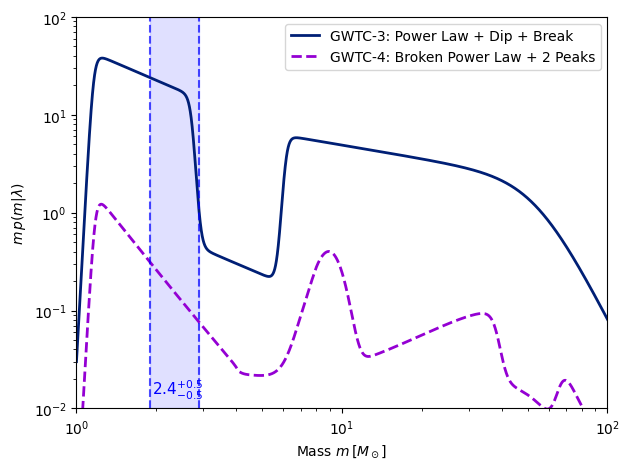

In [5]:
# evaluate both models

# figure setup
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")

# violet: '#9400D3', navy: '#001F75'
ax.plot(
    m, m * gwtc3, color="#001F75", linewidth=2, label="GWTC-3: Power Law + Dip + Break"
)
ax.plot(
    m,
    m * gwtc4,
    color="#9400D3",
    linewidth=2,
    linestyle="--",
    label="GWTC-4: Broken Power Law + 2 Peaks",
)

# limits and labels
ax.set_xlim(1, 100)
ax.set_ylim(0.01, 100)
ax.set_xlabel(r"Mass $m\,[M_\odot]$")
ax.set_ylabel(r"$m\,p(m|\lambda)$")
ax.legend()

# Mass gap region in light blue, dashed lines
y_min, y_max = ax.get_ylim()
ax.fill_between([1.9, 2.9], y_min, y_max, color="blue", alpha=0.12, zorder=1)
ax.axvline(x=1.9, color="blue", linestyle="--", alpha=0.7)
ax.axvline(x=2.9, color="blue", linestyle="--", alpha=0.7)
ax.text(
    2.4,
    y_min * 1.2,
    r"$2.4^{+0.5}_{-0.5}$",
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="bold",
    color="blue",
)

fig.tight_layout()
plt.savefig("mass_distribution_models.png", dpi=300)
plt.show()

# Process the GWTC-4 generatead distribution 

## 1. Read distribution sample.

In [6]:
filename = "O4_result/baseline5_widesigmachi2_mass_NotchFilterBinnedPairingMassDistribution_redshift_powerlaw_mag_iid_spin_magnitude_gaussian_tilt_iid_spin_orientation_result_events_baseline5_all.h5"

In [7]:
table = Table.read(filename)
table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.4003127807104705,0.934954537546301,0.25226035333012586,0.17081800015796333,-0.07445077428355917,0.9653381954834288,1.4144591708724004,1.3092287883093328
1.6007200708910987,0.9777425764328481,0.14350300511641967,0.05476595988100175,0.8604462381564546,0.7046866211743108,1.3044228619425053,1.5650921662608341


In [8]:
output_gwtc3 = "GWTC-3.h5"
output_gwtc4 = "GWTC-4.h5"

## 2. Convert GWTC-4's distribution to suitable format for bayestar-inject

In [9]:
z = table["redshift"]
distance = cosmo.luminosity_distance(z).to_value(u.Mpc)

gwtc4_samples = Table(
    {
        "mass1": table["mass_1"],
        "mass2": table["mass_2"],
        "spin1z": table["a_1"] * table["cos_tilt_1"],
        "spin2z": table["a_2"] * table["cos_tilt_2"],
        "distance": distance,
    }
)

# Table(
#     {
#         "mass1": table["mass_1"],
#         "mass2": table["mass_2"],
#         "spin1z": table["a_1"] * table["cos_tilt_1"],
#         "spin2z": table["a_2"] * table["cos_tilt_2"],
#         # "distance": distance,
#     }
# ).write(
#    output_gwtc4,
#     overwrite=True
# )

## 3. Number of events in each sub-population

In [10]:
ns_max_mass = 3
source_mass1 = gwtc4_samples["mass1"]
source_mass2 = gwtc4_samples["mass2"]

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

In [11]:
# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 740077
  NSBH : 160672
  BBH  : 99251


## GWTC-3 distribustion

In [12]:
# gwtc3_samples = Table.read("./data/farah.h5")

# gwtc3_samples[:2]

file_url = "https://dcc.ligo.org/LIGO-T2100512/public/O1O2O3all_mass_h_iid_mag_iid_tilt_powerlaw_redshift_maxP_events_all.h5"
file_name = os.path.join("data", file_url.split("/")[-1])
input_file = download_file(file_url, file_name)

In [13]:
gwtc3_table = Table.read(input_file)

z = gwtc3_table["redshift"]
distance = cosmo.luminosity_distance(z).to_value(u.Mpc)

gwtc3_samples = Table(
    {
        "mass1": gwtc3_table["mass_1"],
        "mass2": gwtc3_table["mass_2"],
        "spin1z": gwtc3_table["a_1"] * gwtc3_table["cos_tilt_1"],
        "spin2z": gwtc3_table["a_2"] * gwtc3_table["cos_tilt_2"],
        "distance": distance,
    }
)

In [14]:
gwtc3_table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.6334784673051967,0.8454894156909176,0.017967576173918476,0.16004897675006174,0.031869301994897015,-0.07514292551559631,1.4449414896699722,1.3810887548655666
2.4116235511053596,0.8454587847570831,0.3488277731583293,0.15886112907941302,0.27419198147524115,0.810559577143116,0.4689085689630565,2.038928316809099


In [15]:
ns_max_mass = 3
source_mass1 = gwtc3_samples["mass1"]
source_mass2 = gwtc3_samples["mass2"]

# classify systems

BNS = np.sum((source_mass1 < ns_max_mass) & (source_mass2 < ns_max_mass))
NSBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 < ns_max_mass))
BBH = np.sum((source_mass1 >= ns_max_mass) & (source_mass2 >= ns_max_mass))

# print results
print("CBC classification results:")
print(f"  BNS  : {BNS}")
print(f"  NSBH : {NSBH}")
print(f"  BBH  : {BBH}")

CBC classification results:
  BNS  : 892762
  NSBH : 35962
  BBH  : 71276


# KS Test

In [16]:
gwtc3_samples["log10_distance"] = np.log10(gwtc3_samples["distance"])
gwtc4_samples["log10_distance"] = np.log10(gwtc4_samples["distance"])

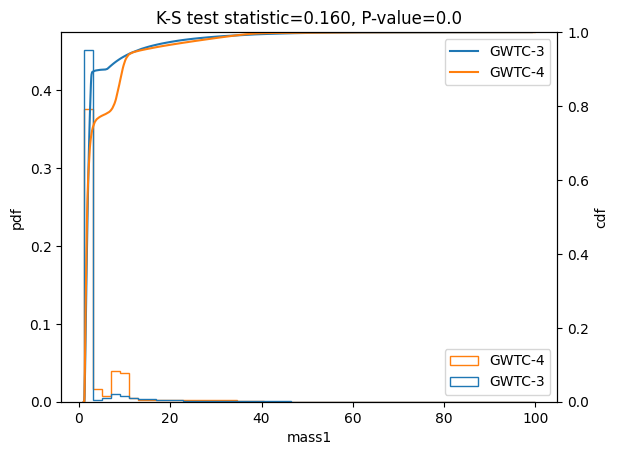

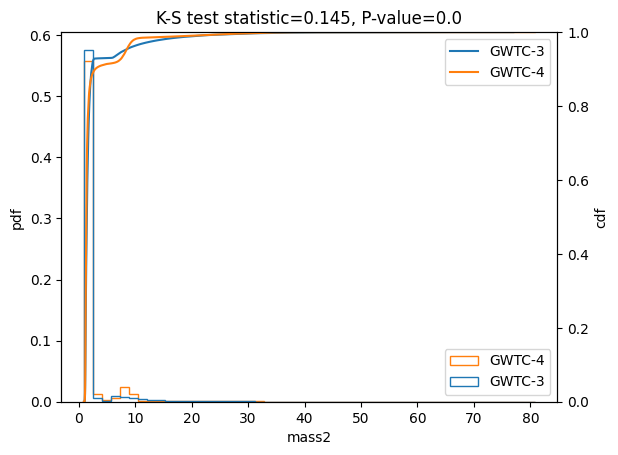

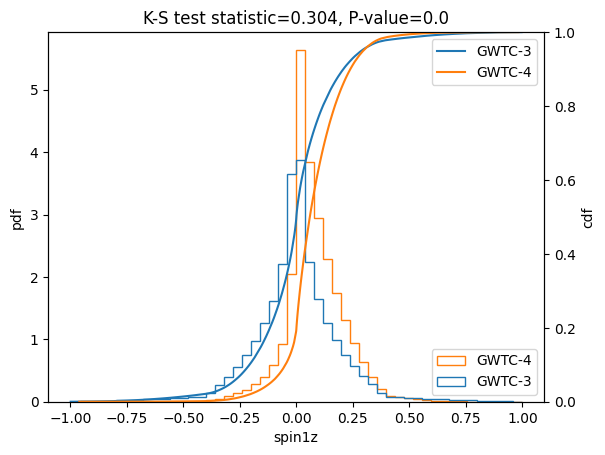

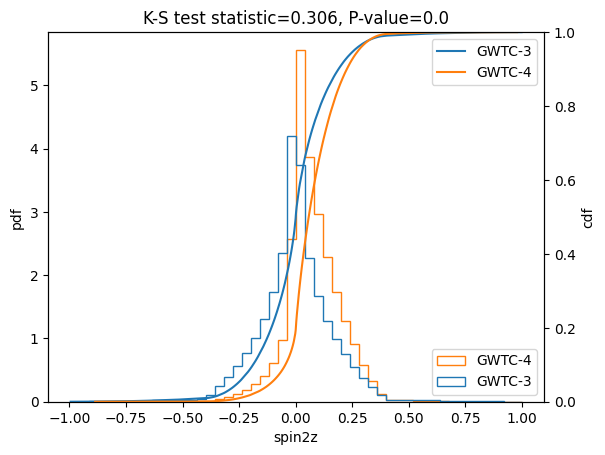

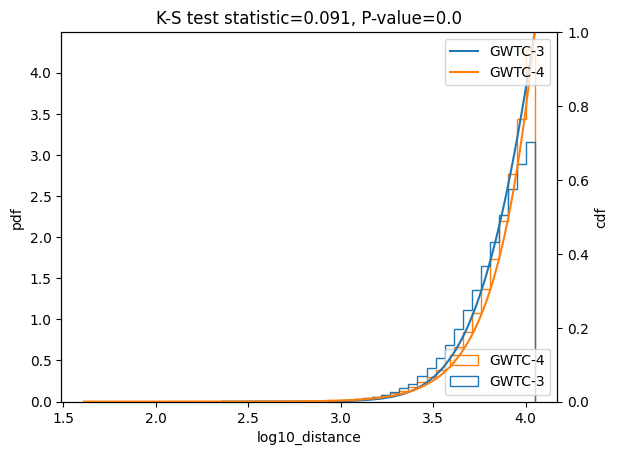

In [21]:
for col in ["mass1", "mass2", "spin1z", "spin2z", "log10_distance"]:
    fig, ax = plt.subplots()
    ax.hist(
        [gwtc3_samples[col], gwtc4_samples[col]],
        label=["GWTC-3", "GWTC-4"],
        histtype="step",
        density=1,
        bins=50,
    )
    ax.set_ylim(0, None)
    ax.set_ylabel("pdf")
    ax2 = ax.twinx()
    ax2.set_ylabel("cdf")
    ax2.set_ylim(0, 1)
    ax2.plot(
        np.sort(gwtc3_samples[col]),
        np.linspace(0, 1, len(gwtc3_samples)),
        label="GWTC-3",
    )
    ax2.plot(
        np.sort(gwtc4_samples[col]),
        np.linspace(0, 1, len(gwtc4_samples)),
        label="GWTC-4",
    )
    ax.legend(loc="lower right")
    ax2.legend(loc="upper right")
    stat, pvalue = ks_2samp(gwtc3_samples[col], gwtc4_samples[col])
    ax.set_xlabel(col)
    ax.set_title(f"K-S test statistic={stat:0.3f}, P-value={pvalue}")
    fig.savefig(f"ks_{col}.png", dpi=300)